# Tweet Sentiment Classification

## Goal
The goal is to classify the sentiment of tweets from four technology companies, Apple, Microsoft, Google, and Twitter. The sentiment level are positive, neutral, or negative sentiment.


# Load the Data

The training data is in the text file `sanders_tweets_train.txt`.  This CSV file contains the  tweet, labels, and topics. The class labels are: `"positive"`, `"neutral"`, and `"negative"`. The training data also includes the corresponding tweet topics: `"apple"`, `"microsoft"`, `"google"`, and `"twitter"`.

The testing data is in the text file `sanders_tweets_test.txt`, and only contains the tweets.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
random.seed(100)

In [2]:
def read_text_data(fname):
    txtdata = []
    classes = []
    topics  = []
    with open(fname, 'r',encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            # get the text
            txtdata.append(row[0])
            # get the class (convert to integer)
            if len(row)>1:
                classes.append(row[1])
                topics.append(row[2])
    
    if (len(classes)>0) and (len(txtdata) != len(classes)):        
        raise Exception("mismatched length!")
    
    return (txtdata, classes, topics)

def write_csv_kaggle_sub(fname, Y):
    # fname = file name
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        tmp2 = [(i+1), y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [3]:
import pandas as pd
train_df = pd.read_csv("sanders_tweets_train.txt", header = None, names=['tweet', 'sentiment', 'topic'])
test_df = pd.read_csv("sanders_tweets_test.txt", header = None, names=['tweet'])
train_df

,tweet,sentiment,topic
0,http://t.co/QV4m1Un9 Forget the phone.. Nice U...,positive,google
1,I hate when my phne do what it want on #twitter,neutral,twitter
2,…and only the first 23 images in my Photo Roll...,negative,apple
3,The lock screen now has facial recognition cap...,neutral,google
4,#TeamGoogleNexus RT @B__Y #Google + #Samsung =...,neutral,google
...,...,...,...
2391,@karth_vader_ when did you change your nick ag...,neutral,twitter
2392,GoodNight #Twitter:),neutral,twitter
2393,@AndroidPolice Duly noted -- I hope AOSP is up...,neutral,google
2394,#Microsoft's plan for bringing its #BI tools t...,neutral,microsoft


## Exploratory data analysis

In [4]:
def count_values_by_column(data, columnname):
    total = data.loc[:,columnname].value_counts(dropna=False)
    percentage = round(data.loc[:,columnname].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [5]:
# The percentage of each sentiment level
count_values_by_column(train_df,'sentiment')

,Total,Percentage
neutral,1630,68.03
negative,403,16.82
positive,363,15.15


In [6]:
# The percentage of each topic
count_values_by_column(train_df,'topic')

,Total,Percentage
apple,703,29.34
microsoft,622,25.96
google,586,24.46
twitter,485,20.24


In [7]:
import re
def search_link(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return "".join(url) 

In [8]:
# URL Count per sentiment level
train_df['URL']= train_df['tweet'].apply(lambda x: search_link(x))
df=pd.DataFrame(train_df.loc[train_df['URL']!=""]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "url_count"})

,sentiment,url_count
0,neutral,871
1,positive,109
2,negative,78


In [9]:
#Punctuations
def search_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

In [10]:
train_df['Punctuation'] = train_df['tweet'].apply(lambda x: search_punct(x))
train_df['Punctuation_Length'] = train_df['tweet'].apply(lambda x: len(search_punct(x)))

In [11]:
df=pd.DataFrame(train_df.loc[train_df['Punctuation_Length'] > 0]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "Punctuation_Length"})

,sentiment,Punctuation_Length
0,neutral,1630
1,negative,403
2,positive,363


In [12]:
punc_df=pd.DataFrame(train_df,columns=['Punctuation','sentiment'])
punc_df=punc_df[punc_df['Punctuation'].map(lambda d: len(d)) > 0]

punc_df=punc_df.explode('Punctuation')

pos_df=pd.DataFrame(punc_df.loc[punc_df['sentiment']=="positive"]['Punctuation'].value_counts()).reset_index().rename(columns={'index': 'punct','Punctuation':'count'})
neg_df=pd.DataFrame(punc_df.loc[punc_df['sentiment']=="negative"]['Punctuation'].value_counts()).reset_index().rename(columns={'index': 'punct','Punctuation':'count'})
neu_df=pd.DataFrame(punc_df.loc[punc_df['sentiment']=="neutral"]['Punctuation'].value_counts()).reset_index().rename(columns={'index': 'punct','Punctuation':'count'})

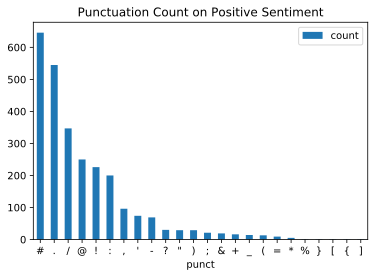

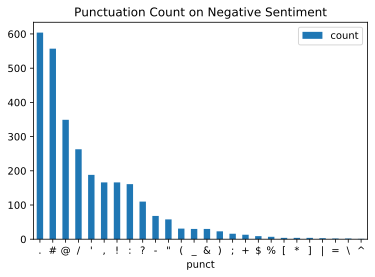

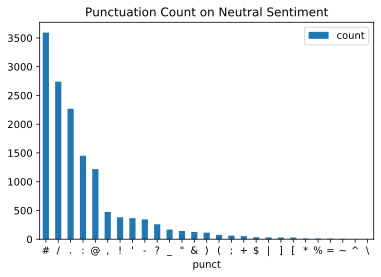

In [13]:
ax = pos_df.plot.bar(x='punct', y='count', rot=0, title='Punctuation Count on Positive Sentiment')
ax = neg_df.plot.bar(x='punct', y='count', rot=0, title='Punctuation Count on Negative Sentiment')
ax = neu_df.plot.bar(x='punct', y='count', rot=0, title='Punctuation Count on Neutral Sentiment')

## Find the common words

In [14]:
train_df[train_df['sentiment'] == 'positive']['tweet']

0       http://t.co/QV4m1Un9 Forget the phone.. Nice U...
7       RT @bmann Awesome! @TommyLee is moving to #Van...
9       Thank you @apple for your innovations. Exhibit...
10      I cannot wait for a new #ICS phone!!! #Google ...
18      Soon. Getting ready for the party. #google #an...
                              ...                        
2366    OMG :) :) #Microsoft #Sharepoint is actually w...
2368    Lmfao look at the argument I had with Siri !!\...
2377    #Android #Google Device Frame Generator Update...
2383    I've pretty much abandoned Facebook for Twitte...
2388    Telegraph reports that the biggest threat to #...
Name: tweet, Length: 363, dtype: object

In [15]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfredli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfredli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alfredli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
from collections import defaultdict
def corpus_sentiment(data, feature, sentiment):
    corpus=[]
    for x in data[data['sentiment'] == sentiment][feature].str.split():
        for i in x:
            corpus.append(i)
            
    dic=defaultdict(int)
    for word in corpus:
        if word not in stopWords:
            dic[word]+=1
   
    #print(dic[0])
    common_word_cntlist=sorted(dic.items(), key=lambda x:x[1], reverse=True)
    #print(top)
    x,y=zip(*common_word_cntlist)
    return x,y

corpus_sentiment(train_df,'tweet','positive')[1][:2]

(82, 71)

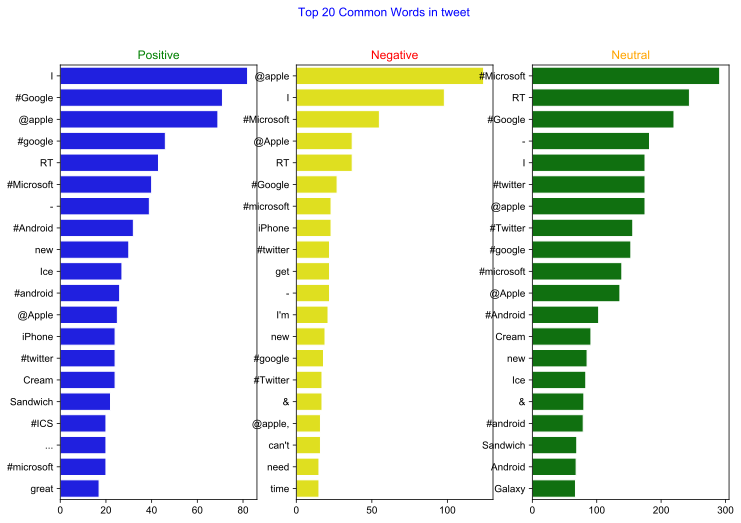

In [17]:
import matplotlib.pyplot as plt

import seaborn as sns

topnum = 20
f, axes = plt.subplots(1,3,figsize=(12,8))
sns.set(font_scale =1)
sns.barplot(y=list(corpus_sentiment(train_df,'tweet','positive')[0])[:topnum], 
            x= list(corpus_sentiment(train_df,'tweet','positive')[1])[:topnum],
            color="blue",ax=axes[0]).set_title("Positive",color="green")
sns.barplot(y=list(corpus_sentiment(train_df,'tweet','negative')[0])[:topnum], 
            x=list(corpus_sentiment(train_df,'tweet','negative')[1])[:topnum],
            color="yellow", ax=axes[1]).set_title("Negative",color="red")
sns.barplot(y=list(corpus_sentiment(train_df,'tweet','neutral')[0])[:topnum], 
            x=list(corpus_sentiment(train_df,'tweet','neutral')[1])[:topnum],
            color="green", ax=axes[2]).set_title("Neutral",color="orange")

plt.suptitle("Top 20 Common Words in tweet" ,fontsize=12,color="blue")
plt.show()

### Observation:

Refer to the Top 20 common words, some brand names which has no meaning for sentiment prediction can be removed.  
Here is the list:  
rw_list = ["apple", "google", "microsoft", "twitter", "android", "iphone", "galaxy","sandwich","ice", "cream"]
We will repeat to draw the top 20 after data processing and review any common words.


In [18]:
# load the data
#(traintxt, trainY, traintopic) = read_text_data("sanders_tweets_train.txt")
#(testtxt, _, _)                = read_text_data("sanders_tweets_test.txt")

#print(len(traintxt))
#print(len(testtxt))

# Data Preprocessing

## Define Stemming, Lemmatization, and remove stopwords function

In [19]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words=word_tokenize(sentence)
    #token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

x=stemSentence("friend friends run ran")
print(x)
import nltk

from nltk.stem import WordNetLemmatizer
def lemmatizeSentence(sentence):
    wordnet_lemmatizer = WordNetLemmatizer()
    token_words = nltk.word_tokenize(sentence)
    lemm_sentence =[]
    for word in token_words:
        lemm_sentence.append(wordnet_lemmatizer.lemmatize(word))
        lemm_sentence.append(" ")
    return "".join(lemm_sentence)

def rmSWSentence(sentence):
    stopWords = set(stopwords.words('english'))
    token_words = nltk.word_tokenize(sentence)
    rmsw_sentence =[]
    for word in token_words:
        if word not in stopWords:
            rmsw_sentence.append(word)
            rmsw_sentence.append(" ")
    return "".join(rmsw_sentence)

x=rmSWSentence("i am a boy")
print(x)


friend friend run ran 
boy 


In [20]:
#Remove some words, punctuation, To lower case and Stemming
rw_list = ["http:", "apple", "google", "microsoft", "twitter", "android", "iphone", "samsung", "windows", "galaxy","nexus","sandwich","ice cream","sandwich","facebook","siri"]
import re
import string
rw_traintxt = []
table = str.maketrans(dict.fromkeys(string.punctuation)) 

def data_processing(w):
    nw = w.lower()
    nw = re.sub("|".join(rw_list), "", nw)  
    nw = nw.translate(table)
    nw = ''.join([i for i in nw if not i.isdigit()]) 
    nw = stemSentence(nw)
    nw = lemmatizeSentence(nw)
    nw = rmSWSentence(nw)
    return nw 
'''  
for w in traintxt:
    nw = w.lower()
    nw = re.sub("|".join(rw_list), "", nw)  
    nw = nw.translate(table)
    nw = ''.join([i for i in nw if not i.isdigit()]) 
    nw = stemSentence(nw)
    nw = lemmatizeSentence(nw)
    nw = rmSWSentence(nw)
    rw_traintxt.append(nw)

rw_testtxt = []
for w in testtxt:
    nw = w.lower()
    nw = re.sub("|".join(rw_list), "", nw)
    nw = nw.translate(table)
    nw = ''.join([i for i in nw if not i.isdigit()]) 
    nw = stemSentence(nw)
    nw = lemmatizeSentence(nw)
    nw = rmSWSentence(nw)
    rw_testtxt.append(nw)
'''
train_df['rw_tweet'] = train_df['tweet'].apply(lambda x: data_processing(x))
test_df['rw_tweet'] = test_df['tweet'].apply(lambda x: data_processing(x))

In [21]:
#Label encoder method 1
#train_df['sentiment_code'] = train_df['sentiment'].astype('category').cat.codes
#train_df['topic_code'] = train_df['topic'].astype('category').cat.codes
#train_df.head(5)

In [22]:
## sklearn encoder
from sklearn.preprocessing import LabelEncoder

labelencoder_Y = LabelEncoder()
labelencoder_topic = LabelEncoder()

# apply le on categorical feature columns
train_df['sentiment_code'] = labelencoder_Y.fit_transform(train_df['sentiment'])
train_df['topic_code'] = labelencoder_topic.fit_transform(train_df['topic'])
#train_df['topic_code'] = train_df['topic'].apply(lambda col: labelencoder_topic.fit_transform(col))
train_df.head(5)

,tweet,sentiment,topic,URL,Punctuation,Punctuation_Length,rw_tweet,sentiment_code,topic_code
0,http://t.co/QV4m1Un9 Forget the phone.. Nice U...,positive,google,http://t.co/QV4m1Un9,"[:, /, /, ., /, ., ., ., #, #, #]",11,tcoqvmun forget phone nice ui like scroll featur,2,1
1,I hate when my phne do what it want on #twitter,neutral,twitter,,[#],1,hate phne want,1,3
2,…and only the first 23 images in my Photo Roll...,negative,apple,,"[?, ,, @, ,, ?]",5,…and onli first imag photo roll made serious f...,0,0
3,The lock screen now has facial recognition cap...,neutral,google,,"[!, #, #, #]",4,lock screen ha facial recognit capabl ic,1,1
4,#TeamGoogleNexus RT @B__Y #Google + #Samsung =...,neutral,google,,"[#, @, _, _, #, +, #, =, #, #]",10,team rt perfect icecream,1,1


## Features Generation
a.	Word Count: The number of words of each tweet  
b.	Stop words percentage: The percentage of stop words in each tweet  
c.	Non-stop words percentage: The percentage of non-stop words in each tweet  
d.	Is Contain URL: 1 represent URL exists in tweet, otherwise 0  
e.	Punctuation percentage: The percentage of punctuation in each tweet  
f.	Positive words percentage: The percentage of positive words in each tweet  
g.	Negative words percentage: The percentage of negative words in each tweet  
h.	Neutral words percentage: The percentage of neutral words in each tweet  

In [23]:
import pandas as pd
tweetDf = train_df
#tweetDf = pd.DataFrame({'tweet': traintxt, 'rw_tweet':rw_traintxt, 'topic': traintopic, 'class': trainY})
tweetDf["word_Count"] = tweetDf['tweet'].apply(lambda x: len(x))
tweetDf['rwsw_count'] = tweetDf['rw_tweet'].apply(lambda x: len(x))
tweetDf['rwsw_percent'] = tweetDf['rwsw_count']/tweetDf["word_Count"]
tweetDf['sw_count'] = tweetDf["word_Count"] - tweetDf['rwsw_count']
tweetDf['sw_percent'] = tweetDf['sw_count']/tweetDf["word_Count"]
tweetDf["href_tweet"] = tweetDf['tweet'].str.contains("http").astype(int)
tweetDf["punc_tweet"] = tweetDf['tweet'].apply(lambda x: [w for w in x if w in string.punctuation])
tweetDf['punc_count'] = tweetDf['punc_tweet'].apply(lambda x: len(x))
tweetDf['punc_percent'] = tweetDf['punc_count']/tweetDf["word_Count"]

#tweet_test_Df = pd.DataFrame({'tweet': testtxt, 'rw_tweet':rw_testtxt})
tweet_test_Df = test_df
tweet_test_Df["word_Count"] = tweet_test_Df['tweet'].apply(lambda x: len(x))
tweet_test_Df['rwsw_count'] = tweet_test_Df['rw_tweet'].apply(lambda x: len(x))
tweet_test_Df['rwsw_percent'] = tweet_test_Df['rwsw_count']/tweet_test_Df["word_Count"]
tweet_test_Df['sw_count'] = tweet_test_Df["word_Count"] - tweet_test_Df['rwsw_count']
tweet_test_Df['sw_percent'] = tweet_test_Df['sw_count']/tweet_test_Df["word_Count"]
tweet_test_Df["href_tweet"] = tweet_test_Df['tweet'].str.contains("http").astype(int)
tweet_test_Df["punc_tweet"] = tweet_test_Df['tweet'].apply(lambda x: [w for w in x if w in string.punctuation])
tweet_test_Df['punc_count'] = tweet_test_Df['punc_tweet'].apply(lambda x: len(x))
tweet_test_Df['punc_percent'] = tweet_test_Df['punc_count']/tweet_test_Df["word_Count"]

In [24]:
tweetDf.columns

Index(['tweet', 'sentiment', 'topic', 'URL', 'Punctuation',
       'Punctuation_Length', 'rw_tweet', 'sentiment_code', 'topic_code',
       'word_Count', 'rwsw_count', 'rwsw_percent', 'sw_count', 'sw_percent',
       'href_tweet', 'punc_tweet', 'punc_count', 'punc_percent'],
      dtype='object')

In [25]:
from collections import Counter

def createwordsList(classes):
    Df = tweetDf[tweetDf['sentiment']==classes]
    Count = Counter(" ".join(Df["rw_tweet"]).split()).most_common(25)

    Words1=[]
    for i in range(25):
        Words1.append(Count[i][0])
    return Words1

ngWord = createwordsList('negative')
posWord = createwordsList('positive')
neuWord = createwordsList('neutral')


In [26]:
#tweetDf["neg_tweet"] = tweetDf['rw_tweet'].apply(lambda x: [w for w in x if w in ngWord]).apply(lambda x: len(x))
#tweetDf["pos_tweet"] = tweetDf['rw_tweet'].apply(lambda x: [w for w in x if w in posWord]).apply(lambda x: len(x))
tweetDf["neg_tweet"] = tweetDf['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in ngWord]).apply(lambda x: len(x))
tweetDf["pos_tweet"] = tweetDf['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in posWord]).apply(lambda x: len(x))
tweetDf["neu_tweet"] = tweetDf['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in neuWord]).apply(lambda x: len(x))

tweetDf["neg_pec_tweet"] = tweetDf["neg_tweet"]/(tweetDf["neg_tweet"] + tweetDf["pos_tweet"] + tweetDf["neu_tweet"])
tweetDf["pos_pec_tweet"] = tweetDf["pos_tweet"]/(tweetDf["neg_tweet"] + tweetDf["pos_tweet"] + tweetDf["neu_tweet"])
tweetDf["neu_pec_tweet"] = tweetDf["neu_tweet"]/(tweetDf["neg_tweet"] + tweetDf["pos_tweet"] + tweetDf["neu_tweet"])

tweetDf["neg_pec_tweet"].fillna(0, inplace = True)
tweetDf["pos_pec_tweet"].fillna(0, inplace = True)
tweetDf["neu_pec_tweet"].fillna(0, inplace = True)

tweet_test_Df["neg_tweet"] = tweet_test_Df['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in ngWord]).apply(lambda x: len(x))
tweet_test_Df["pos_tweet"] = tweet_test_Df['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in posWord]).apply(lambda x: len(x))
tweet_test_Df["neu_tweet"] = tweet_test_Df['rw_tweet'].apply(lambda x: [w for w in x.split(' ') if w in neuWord]).apply(lambda x: len(x))

tweet_test_Df["neg_pec_tweet"] = tweet_test_Df["neg_tweet"]/(tweet_test_Df["neg_tweet"] + tweet_test_Df["pos_tweet"] + tweet_test_Df["neu_tweet"])
tweet_test_Df["pos_pec_tweet"] = tweet_test_Df["pos_tweet"]/(tweet_test_Df["neg_tweet"] + tweet_test_Df["pos_tweet"] + tweet_test_Df["neu_tweet"])
tweet_test_Df["neu_pec_tweet"] = tweet_test_Df["neu_tweet"]/(tweet_test_Df["neg_tweet"] + tweet_test_Df["pos_tweet"] + tweet_test_Df["neu_tweet"])

tweet_test_Df["neg_pec_tweet"].fillna(0, inplace = True)
tweet_test_Df["pos_pec_tweet"].fillna(0, inplace = True)
tweet_test_Df["neu_pec_tweet"].fillna(0, inplace = True)

In [27]:
tweetDf[tweetDf['sentiment']=='positive']
#tweetDf["pos_pec_tweet"].isnull()

,tweet,sentiment,topic,URL,Punctuation,Punctuation_Length,rw_tweet,sentiment_code,topic_code,word_Count,...,href_tweet,punc_tweet,punc_count,punc_percent,neg_tweet,pos_tweet,neu_tweet,neg_pec_tweet,pos_pec_tweet,neu_pec_tweet
0,http://t.co/QV4m1Un9 Forget the phone.. Nice U...,positive,google,http://t.co/QV4m1Un9,"[:, /, /, ., /, ., ., ., #, #, #]",11,tcoqvmun forget phone nice ui like scroll featur,2,1,98,...,1,"[:, /, /, ., /, ., ., ., #, #, #]",11,0.112245,1,2,2,0.200000,0.400000,0.400000
7,RT @bmann Awesome! @TommyLee is moving to #Van...,positive,microsoft,,"[@, !, @, #, #, -]",6,rt bmann awesom tommyle move vancouv dev evang...,2,2,110,...,0,"[@, !, @, #, #, -]",6,0.054545,2,3,2,0.285714,0.428571,0.285714
9,Thank you @apple for your innovations. Exhibit...,positive,apple,http://t.co/oU7K39ge,"[@, ., :, ., :, /, /, ., /]",9,thank innov exhibit guy play facetim instead w...,2,0,136,...,1,"[@, ., :, ., :, /, /, ., /]",9,0.066176,1,1,0,0.500000,0.500000,0.000000
10,I cannot wait for a new #ICS phone!!! #Google ...,positive,google,,"[#, !, !, !, #, #]",6,wait new ic phone,2,1,54,...,0,"[#, !, !, !, #, #]",6,0.111111,2,3,3,0.250000,0.375000,0.375000
18,Soon. Getting ready for the party. #google #an...,positive,google,http://t.co/eZjCzLt6,"[., ., #, #, #, :, /, /, ., /]",10,soon get readi parti icecream tcoezjczlt,2,1,90,...,1,"[., ., #, #, #, :, /, /, ., /]",10,0.111111,1,2,2,0.200000,0.400000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,OMG :) :) #Microsoft #Sharepoint is actually w...,positive,microsoft,,"[:, ), :, ), #, #, !]",7,omg sharepoint actual work thank excel colleag...,2,2,95,...,0,"[:, ), :, ), #, #, !]",7,0.073684,2,1,0,0.666667,0.333333,0.000000
2368,Lmfao look at the argument I had with Siri !!\...,positive,apple,http://t.co/D4VjL7SI,"[!, !, @, @, :, /, /, ., /]",9,lmfao look argument ijustin tcodvjlsi,2,0,83,...,1,"[!, !, @, @, :, /, /, ., /]",9,0.108434,0,1,0,0.000000,1.000000,0.000000
2377,#Android #Google Device Frame Generator Update...,positive,google,http://t.co/9bWt2W6z,"[#, #, -, :, /, /, ., /, #]",9,devic frame gener updat screenshot got prettie...,2,1,134,...,1,"[#, #, -, :, /, /, ., /, #]",9,0.067164,1,0,1,0.500000,0.000000,0.500000
2383,I've pretty much abandoned Facebook for Twitte...,positive,twitter,,"[', ., #, ']",4,ive pretti much abandon slegit,2,3,64,...,0,"[', ., #, ']",4,0.062500,0,0,0,0.000000,0.000000,0.000000


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
text = Pipeline([
                ('selector', TextSelector(key='rw_tweet')),
                ('tfidf', TfidfVectorizer(stop_words='english',ngram_range=(1, 4)))
            ])
words_count =  Pipeline([
                ('selector', NumberSelector(key='word_Count')),
                ('standard', StandardScaler())
            ])
words_sw_count =  Pipeline([
                ('selector', NumberSelector(key='sw_count')),
                ('standard', StandardScaler())
            ])
words_sw_percent =  Pipeline([
                ('selector', NumberSelector(key='sw_percent')),
                ('standard', StandardScaler())
            ])

words_rwsw_count =  Pipeline([
                ('selector', NumberSelector(key='rwsw_count')),
                ('standard', StandardScaler())
            ])
words_rwsw_percent =  Pipeline([
                ('selector', NumberSelector(key='rwsw_percent')),
                ('standard', StandardScaler())
            ])
words_href =  Pipeline([
                ('selector', NumberSelector(key='href_tweet'))
            ])
words_pos_count =  Pipeline([
                ('selector', NumberSelector(key='pos_tweet')),
                ('standard', StandardScaler())
            ])
words_neg_count =  Pipeline([
                ('selector', NumberSelector(key='neg_tweet')),
                ('standard', StandardScaler())
            ])
words_neu_count =  Pipeline([
                ('selector', NumberSelector(key='neu_tweet')),
                ('standard', StandardScaler())
            ])

words_pos_pec =  Pipeline([
                ('selector', NumberSelector(key='pos_pec_tweet')),
                ('standard', StandardScaler())
            ])
words_neg_pec =  Pipeline([
                ('selector', NumberSelector(key='neg_pec_tweet')),
                ('standard', StandardScaler())
            ])
words_neu_pec =  Pipeline([
                ('selector', NumberSelector(key='neu_pec_tweet')),
                ('standard', StandardScaler())
            ])

punc_length =  Pipeline([
                ('selector', NumberSelector(key='punc_count')),
                ('standard', StandardScaler())
            ])
punc_percent =  Pipeline([
                ('selector', NumberSelector(key='punc_percent')),
                ('standard', StandardScaler())
            ])


In [30]:
tweetDf.head(5)

,tweet,sentiment,topic,URL,Punctuation,Punctuation_Length,rw_tweet,sentiment_code,topic_code,word_Count,...,href_tweet,punc_tweet,punc_count,punc_percent,neg_tweet,pos_tweet,neu_tweet,neg_pec_tweet,pos_pec_tweet,neu_pec_tweet
0,http://t.co/QV4m1Un9 Forget the phone.. Nice U...,positive,google,http://t.co/QV4m1Un9,"[:, /, /, ., /, ., ., ., #, #, #]",11,tcoqvmun forget phone nice ui like scroll featur,2,1,98,...,1,"[:, /, /, ., /, ., ., ., #, #, #]",11,0.112245,1,2,2,0.20,0.4,0.40
1,I hate when my phne do what it want on #twitter,neutral,twitter,,[#],1,hate phne want,1,3,47,...,0,[#],1,0.021277,0,1,0,0.00,1.0,0.00
2,…and only the first 23 images in my Photo Roll...,negative,apple,,"[?, ,, @, ,, ?]",5,…and onli first imag photo roll made serious f...,0,0,113,...,0,"[?, ,, @, ,, ?]",5,0.044248,3,1,1,0.60,0.2,0.20
3,The lock screen now has facial recognition cap...,neutral,google,,"[!, #, #, #]",4,lock screen ha facial recognit capabl ic,1,1,76,...,0,"[!, #, #, #]",4,0.052632,1,2,1,0.25,0.5,0.25
4,#TeamGoogleNexus RT @B__Y #Google + #Samsung =...,neutral,google,,"[#, @, _, _, #, +, #, =, #, #]",10,team rt perfect icecream,1,1,86,...,0,"[#, @, _, _, #, +, #, =, #, #]",10,0.116279,1,2,2,0.20,0.4,0.40


In [31]:
from sklearn.utils import shuffle
tweetDf = shuffle(tweetDf)
tweetDf.head(5)
sentiment_label = tweetDf['sentiment_code']
tweetDf.drop(['tweet','sentiment', 'topic','punc_tweet','sw_count','rwsw_count','pos_tweet','neg_tweet','neu_tweet','punc_count'], axis=1)

,URL,Punctuation,Punctuation_Length,rw_tweet,sentiment_code,topic_code,word_Count,rwsw_percent,sw_percent,href_tweet,punc_percent,neg_pec_tweet,pos_pec_tweet,neu_pec_tweet
1826,,"[@, _, :, @, ., @]",6,rt deblavoy nice guy store replac phone grati ...,2,0,139,0.561151,0.438849,0,0.043165,0.300000,0.400000,0.300000
636,http://t.co/xEKwTlUg,"[#, ,, :, /, /, ., /]",7,earn disappoint blame consum pc sale tcoxekwtlug,1,2,79,0.620253,0.379747,1,0.088608,0.000000,0.000000,0.000000
231,http://t.co/S0VxsRuU,"[#, -, #, #, @, :, /, /, ., /, #]",11,new exam question avail techxam tcosvxsruu,1,2,84,0.511905,0.488095,1,0.130952,0.250000,0.250000,0.500000
1322,http://t.co/vWpuA2gt,"[:, /, /, ., /, #, #, #, #]",9,tcovwpuagt ic,1,1,75,0.186667,0.813333,1,0.120000,0.000000,0.500000,0.500000
1283,http://t.co/QcDddYrn,"[., #, ?, :, /, /, ., /]",8,onlin music industri wit astound revolut manag...,1,1,131,0.595420,0.404580,1,0.061069,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,,"[@, ., ., ., @, ?, ?, #, ., ., ., #, &, ;]",14,ammmylewi carsonfratu ditch sleep weirdo gtsleep,2,3,92,0.532609,0.467391,0,0.152174,0.000000,0.000000,0.000000
1930,,"[@, _, ', #, #]",5,drealrog sleep n noez u call sleep everi sec u...,1,3,129,0.503876,0.496124,0,0.038760,0.428571,0.142857,0.428571
79,http://t.co/Dm4acTYv,"[:, :, /, /, ., /, @, ., .]",9,first weekend sale top four million tcodmactyv...,1,0,120,0.658333,0.341667,1,0.075000,0.285714,0.285714,0.428571
1859,http://t.co/Oe9Imdob,"[;, -, :, /, /, ., /, -, #, #]",10,ballmer confirm nokia phone debut quot tcooeim...,1,2,113,0.539823,0.460177,1,0.088496,0.250000,0.250000,0.500000


In [32]:
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
import numpy as np
from sklearn.decomposition import TruncatedSVD

feats = FeatureUnion([('text', text), 
                      ('words_count', words_count),
                      #('words_sw_count', words_sw_count),
                      ('words_sw_percent', words_sw_percent),
                      #('words_rwsw_count', words_rwsw_count),
                      ('words_rwsw_percent', words_rwsw_percent),
                      ('words_href', words_href),
                      #('words_pos_count', words_pos_count),
                      #('words_neg_count', words_neg_count),
                      #('words_neu_count', words_neu_count),
                      ('words_pos_pec', words_pos_pec),
                      ('words_neg_pec', words_neg_pec),
                      ('words_neu_pec', words_neu_pec),
                      #('punc_length', punc_length),
                      ('punc_percent', punc_percent)
                      ])

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    #AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    BaggingClassifier()
    ]
# Create dictionary with candidate learning algorithms and their hyperparameters
param_list=[]

search_space_1 = [
                 {"classifier": [LogisticRegression()],
                 "classifier__C": logspace(-4,4,20),
                 "classifier__class_weight": ['balanced'],
                 "classifier__multi_class":['auto'],
                 "classifier__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }]
search_space_2 = {
                 "classifier__n_neighbors":[3],
                 "classifier__weights": ['distance','uniform']
                }
search_space_3 = [{"classifier": [SVC(probability=True, kernel='linear', class_weight='balanced')],
                 "classifier__C": logspace(-4,4,20)
                }]
search_space_4 = [{"classifier": [RandomForestClassifier()],
                   "classifier__class_weight": ['balanced','balanced_subsample'],
                 "classifier__n_estimators": [10, 50, 100]
                }]
#search_space_5 = [{"classifier": [AdaBoostClassifier(base_estimator=SVC(class_weight='balanced',probability=True, kernel='linear'))],
#                 "classifier__n_estimators": [10, 50, 100],
#                 "classifier__learning_rate": [0.5, 1, 1.5, 2]
#                }]
search_space_6 = [{"classifier": [AdaBoostClassifier()],
                 "classifier__n_estimators": [10, 50, 100],
                 "classifier__learning_rate": [0.5, 1, 1.5, 2]
                }]
search_space_7 = [{"classifier": [GradientBoostingClassifier()],
                 "classifier__n_estimators": [10, 50, 100]
                }]
search_space_8 = [{"classifier": [BaggingClassifier()],
                 "classifier__n_estimators": [10, 50, 100]
                }]
search_space_9 = [{"classifier": [BaggingClassifier(base_estimator=SVC(class_weight='balanced',probability=True, kernel='linear'))],
                 "classifier__n_estimators": [10, 50, 100]
                }]
param_list.append(search_space_1)
param_list.append(search_space_2)
param_list.append(search_space_3)
param_list.append(search_space_4)
#param_list.append(search_space_5)
param_list.append(search_space_6)
param_list.append(search_space_7)
param_list.append(search_space_8)
param_list.append(search_space_9)

#print(param_list[0])
for classifier, i in zip(classifiers, range(len(classifiers))):
    pipe = Pipeline([('feats', feats),('classifier', classifiers[i])])
    search = GridSearchCV(pipe, param_list[i], cv=8, verbose=0,n_jobs=-1)
    best_model = search.fit(tweetDf,sentiment_label)
    y_pred = best_model.best_estimator_.predict(tweetDf)
    print("Best score:")
    print(best_model.best_score_)
    print("Best parameters found:")
    print(best_model.best_params_)
    print("Accuracy:",metrics.accuracy_score(sentiment_label, y_pred))

Best score:
0.7516736343366779
Best parameters found:
{'classifier': LogisticRegression(C=29.763514416313132, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 29.763514416313132, 'classifier__class_weight': 'balanced', 'classifier__multi_class': 'auto', 'classifier__solver': 'liblinear'}
Accuracy: 0.9991652754590985
Best score:
0.6519105351170569
Best parameters found:
{'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Accuracy: 1.0
Best score:
0.7508514492753624
Best parameters found:
{'classifier': SVC(C=1.623776739188721, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability

In [33]:
feats = FeatureUnion([('text', text), 
                      ('words_count', words_count),
                      ('words_sw_percent', words_sw_percent),
                      ('words_rwsw_percent', words_rwsw_percent),
                      ('words_href', words_href),
                      ('words_pos_pec', words_pos_pec),
                      ('words_neg_pec', words_neg_pec),
                      ('punc_percent', punc_percent)
                      ])
classifierNames = [
    #"LogisticRegression",
    #"KNeighborsClassifier",
    "SVM",
    #"RandomForestClassifier",
    #"AdaBoostClassifier",
    #"GradientBoostingClassifier",
    #"BaggingClassifier",
    "BaggingClassifier_SVM"
    ]
classifiers = [
    #LogisticRegression(),
    #KNeighborsClassifier(),
    SVC(),
    #RandomForestClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    #BaggingClassifier(),
    BaggingClassifier()
    ]
# Create dictionary with candidate learning algorithms and their hyperparameters
param_list=[]

search_space_1 = [
                 {"classifier": [LogisticRegression()],
                 "classifier__C": logspace(-4,4,20),
                 "classifier__class_weight": ['balanced'],
                 "classifier__multi_class":['auto'],
                 "classifier__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }]
search_space_2 = {
                 "classifier__n_neighbors":[3],
                 "classifier__weights": ['distance','uniform']
                }
search_space_3 = [{"classifier": [SVC(probability=True, kernel='linear', class_weight='balanced')],
                 "classifier__C": logspace(-4,4,20)
                }]
search_space_4 = [{"classifier": [RandomForestClassifier()],
                   "classifier__class_weight": ['balanced','balanced_subsample'],
                 "classifier__n_estimators": [10, 50, 100]
                }]
#search_space_5 = [{"classifier": [AdaBoostClassifier(base_estimator=SVC(class_weight='balanced',probability=True, kernel='linear'))],
#                 "classifier__n_estimators": [10, 50, 100],
#                 "classifier__learning_rate": [0.5, 1, 1.5, 2]
#                }]
search_space_6 = [{"classifier": [AdaBoostClassifier()],
                 "classifier__n_estimators": [10, 50, 100],
                 "classifier__learning_rate": [0.5, 1, 1.5, 2]
                }]
search_space_7 = [{"classifier": [GradientBoostingClassifier()],
                 "classifier__n_estimators": [10, 50, 100]
                }]
search_space_8 = [{"classifier": [BaggingClassifier()],
                 "classifier__n_estimators": [10, 50, 100]
                }]
search_space_9 = [{"classifier": [BaggingClassifier(base_estimator=SVC(class_weight='balanced',probability=True, kernel='linear'))],
                 "classifier__n_estimators": [10, 50, 100]
                }]
#param_list.append(search_space_1)
#param_list.append(search_space_2)
param_list.append(search_space_3)
#param_list.append(search_space_4)
#param_list.append(search_space_5)
#param_list.append(search_space_6)
#param_list.append(search_space_7)
#param_list.append(search_space_8)
param_list.append(search_space_9)

#print(param_list[0])
for classifier, i in zip(classifiers, range(len(classifiers))):
    pipe = Pipeline([('feats', feats),('classifier', classifiers[i])])
    search = GridSearchCV(pipe, param_list[i], cv=8, verbose=0,n_jobs=-1)
    best_model = search.fit(tweetDf,sentiment_label)
    y_pred = best_model.best_estimator_.predict(tweet_test_Df)
    print("Best score:")
    print(best_model.best_score_)
    print("Best parameters found:")
    print(best_model.best_params_)
    write_csv_kaggle_sub("my_submission_1-4_pec_"+classifierNames[i]+".csv", labelencoder_Y.inverse_transform(y_pred))

Best score:
0.7500097547380156
Best parameters found:
{'classifier': SVC(C=4.281332398719396, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 4.281332398719396}
Best score:
0.7520944816053512
Best parameters found:
{'classifier': BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight='balanced', coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='linear',
                                     max_iter=-1, probability=True,
                                     random_state=None, shrinking=True,
                                     tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_feature